In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob
import matplotlib.gridspec as gs
import pint_xarray
import cf_xarray as cfxr
from eofs.xarray import Eof

In [2]:
import pandas as pd

In [3]:
from dask.distributed import Client, LocalCluster
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38795,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:36807,Total threads: 1
Dashboard: /proxy/35235/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:45863,


In [4]:
#load in ctrl dataset
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_sst.nc",  use_cftime=True, chunks= {"time":240})
ctrl = ctrl_sst.sst.compute()

In [5]:
def roll_lon(df):
    df.coords['xt_ocean'] = (df.coords['xt_ocean'] + 360) % 360# - 180
    df = df.sortby(df.xt_ocean)
    return df

In [6]:
ctrl = roll_lon(ctrl)

In [7]:
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")
def NINO34_sst(DS):
    return (DS).sel(yt_ocean=slice(-5, 5),xt_ocean=slice(-170, -120)).mean(['yt_ocean', 'xt_ocean'])
def NINO3(DS):
    return ssta(DS).sel(yt_ocean=slice(
         -5, 5),xt_ocean=slice(210, 270)).mean(['yt_ocean', 'xt_ocean'])
def NINO34(DS):
    return ssta(DS).sel(yt_ocean=slice(
         -5, 5),xt_ocean=slice(190, 240)).mean(['yt_ocean', 'xt_ocean'])
def NINO4(DS):
    return ssta(DS).sel(yt_ocean=slice(
         -5, 5),xt_ocean=slice(160, 210)).mean(['yt_ocean', 'xt_ocean'])
def DMI(DS):
    WTIO =  ssta(DS).sel(yt_ocean=slice(
         -10, 10),xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    SETIO =  ssta(DS).sel(yt_ocean=slice(
         -10, 0),xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return (WTIO - SETIO)

In [8]:
def EP_CP_index(DS):
    sst_anom = ssta(DS).drop(['geolon_t','geolat_t'])
    sst_anom = sst_anom.sel(xt_ocean = slice(140, 280), yt_ocean = slice(-15,15))
    coslat = np.cos(np.deg2rad(sst_anom.coords['yt_ocean'].values))
    wgts = np.sqrt(coslat)[..., np.newaxis]
    solver = Eof(sst_anom, weights=wgts)
    pc1 = solver.pcs(npcs=2, pcscaling=1)
    EP = (-pc1[:,0]-pc1[:,1])/np.sqrt(2)
    CP = (-pc1[:,0]+pc1[:,1])/np.sqrt(2)
    return EP,CP

In [9]:
def EP_CP_eof(DS):
    sst_anom = ssta(DS)
    sst_anom = sst_anom.sel(xt_ocean = slice(140, 280), yt_ocean = slice(-15,15))
    coslat = np.cos(np.deg2rad(sst_anom.coords['yt_ocean'].values))
    wgts = np.sqrt(coslat)[..., np.newaxis]
    solver = Eof(sst_anom, weights=wgts)
    eofs_ = solver.eofsAsCovariance(neofs=4)
    return eofs_

In [21]:
def EP_CP_index(DS):
    """
    Calculate the Eastern Pacific (EP) and Central Pacific (CP) indices 
    based on the first two principal components (PCs) from an EOF analysis 
    of sea surface temperature anomalies (SSTAs), with adjustments based 
    on the sign of the EOFs at a specific location (250° longitude, 0° latitude).

    The function first computes the SST anomalies over a specified region 
    (140° to 280° longitude, -15° to 15° latitude) and then performs an EOF analysis.
    The sign of the first two EOFs at the specified location is used to adjust
    the sign of the corresponding PCs. The EP and CP indices are then calculated 
    from these adjusted PCs.

    Parameters:
    -----------
    DS : xarray.Dataset
        A dataset containing sea surface temperature data. The dataset should 
        include 'xt_ocean' and 'yt_ocean' coordinates.

    Returns:
    --------
    tuple of xarray.DataArray
        A tuple containing the EP and CP indices as xarray.DataArray objects.

    Notes:
    ------
    - The function assumes that the input dataset 'DS' has the necessary 
      fields and coordinates for the EOF analysis.
    - The SST anomaly is calculated internally within the function; 
      hence, 'DS' should contain absolute SST values.
    - The function uses the 'eofs.xarray' package for EOF analysis.
    - The weights for the EOF analysis are calculated as the square root 
      of the cosine of latitude.

    Example:
    --------
    >>> ds = xr.open_dataset('sst_data.nc')
    >>> ep_index, cp_index = EP_CP_index(ds)
    >>> print(ep_index, cp_index)
    """
    # Compute SST anomaly and select region
    sst_anom = ssta(DS)
    sst_anom = sst_anom.sel(xt_ocean=slice(140, 280), yt_ocean=slice(-15, 15))
    coslat = np.cos(np.deg2rad(sst_anom.coords['yt_ocean'].values))
    wgts = np.sqrt(coslat)[..., np.newaxis]

    # EOF analysis
    solver = Eof(sst_anom, weights=wgts)
    pcs = solver.pcs(npcs=2, pcscaling=1)

    # Calculate EOFs
    eofs_ = solver.eofsAsCovariance(neofs=4)
    
    # Check sign of EOFs at specific location
    eof1_val = eofs_.sel(mode=0, xt_ocean=250, yt_ocean=0, method="nearest").values
    eof2_val = eofs_.sel(mode=1, xt_ocean=250, yt_ocean=0, method="nearest").values

    # Adjust PCs based on EOF sign
    if eof1_val < 0:
        pc1= -pcs[:, 0]
    else:
        pc1 = pcs[:, 0]
    if eof2_val < 0:
        pc2 = pcs[:, 1]
    else:
        pc2 = -pcs[:, 1]

    # Calculate indices
    EP = (pc1 - pc2) / np.sqrt(2)
    CP = (pc1 + pc2) / np.sqrt(2)

    return EP, CP


In [11]:
ctrl = ctrl.drop(['geolon_t','geolat_t'])

In [15]:
e = EP_CP_eof(ctrl)

In [18]:
e.sel(mode=0, xt_ocean=250, yt_ocean=0, method="nearest").values

array(-1.6553296, dtype=float32)

In [22]:
EP, CP = EP_CP_index(ctrl)

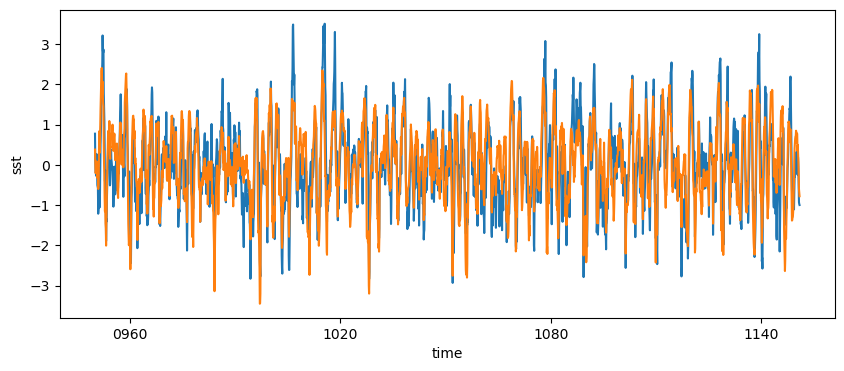

In [23]:
EP.plot(figsize = (10,4))
NINO3(ctrl).plot()

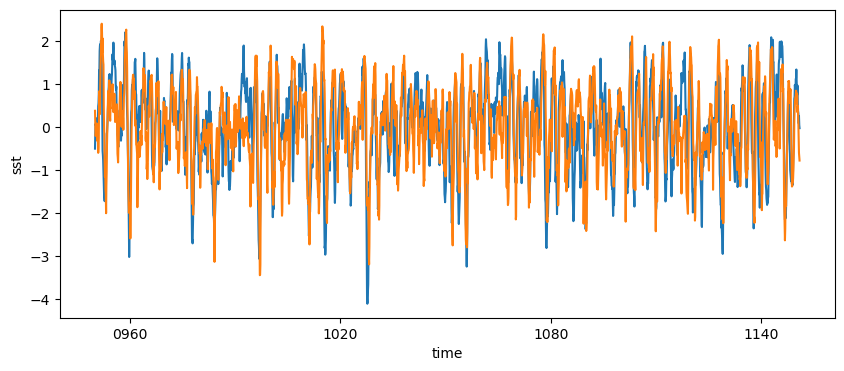

In [24]:
CP.plot(figsize = (10,4))
NINO3(ctrl).plot()

In [25]:
def plot_ssta_and_indices(sst_dataset, ep_index, cp_index, year):
    """
    Plot SSTA for January of a given year, and EP and CP indices for the year and its neighbors.

    Parameters:
    -----------
    sst_dataset : xarray.Dataset
        Dataset containing sea surface temperature data.

    year : int
        The year for which the plot is to be made.
    """
    # Calculate the EP and CP indices
    #ep_index, cp_index = EP_CP_index(sst_dataset)
    #fix year string
    year_str = f"{year:04d}"
    year_str_m1 = f"{year-1:04d}"
    year_str_p1 = f"{year+1:04d}"
    
    fig, axs = plt.subplots(3, 1, figsize=(10, 15), constrained_layout=True)

    # Subplot 1: SSTA for January of the specified year
    sst_anom = ssta(sst_dataset).sel(time=slice(f'{year_str}-01-01', f'{year_str}-01-31'))
    ax = plt.subplot(3, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    sst_anom[0].plot.contourf(ax=ax, transform=ccrs.PlateCarree(central_longitude=0),
                              levels=10, extend='both', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.coastlines()
    ax.set_title(f'SSTA for January {year}')

    # Subplot 2: EP index
    ax = plt.subplot(3, 1, 2)
    ep_index_year = ep_index.sel(time=slice(f'{year_str_m1}-01-01', f'{year_str_p1}-12-31'))
    ep_index_year.plot(ax=ax)
    ax.axvline(cftime.DatetimeGregorian(year, 1, 1), color='k', linestyle='--')
    ax.axvline(cftime.DatetimeGregorian(year, 12, 31), color='k', linestyle='--')
    std_dev = ep_index.std(dim='time')
    ax.axhline(std_dev, color='r', linestyle='--', lw=0.5)
    ax.axhline(-std_dev, color='r', linestyle='--', lw=0.5)
    ax.set_title('EP Index')

    # Subplot 3: CP index
    ax = plt.subplot(3, 1, 3)
    cp_index_year = cp_index.sel(time=slice(f'{year_str_m1}-01-01', f'{year_str_p1}-12-31'))
    cp_index_year.plot(ax=ax)
    ax.axvline(cftime.DatetimeGregorian(year, 1, 1), color='k', linestyle='--')
    ax.axvline(cftime.DatetimeGregorian(year, 12, 31), color='k', linestyle='--')
    std_dev = cp_index.std(dim='time')
    ax.axhline(std_dev, color='r', linestyle='--', lw=0.5)
    ax.axhline(-std_dev, color='r', linestyle='--', lw=0.5)
    ax.set_title('CP Index')
    return fig


In [92]:
#now craete loop

In [26]:
for year in range(960, 1150, 10):
    print(f"starting {year} plotting")
    a = plot_ssta_and_indices(ctrl, EP, CP, year)
    a.savefig(f"/home/561/sm2435/figures/restart_info/restart_{year:04d}.png", bbox_inches='tight')
    print(f"saved {year}")
    plt.close(a)


starting 960 plotting
saved 960
starting 970 plotting
saved 970
starting 980 plotting
saved 980
starting 990 plotting
saved 990
starting 1000 plotting
saved 1000
starting 1010 plotting
saved 1010
starting 1020 plotting
saved 1020
starting 1030 plotting
saved 1030
starting 1040 plotting
saved 1040
starting 1050 plotting
saved 1050
starting 1060 plotting
saved 1060
starting 1070 plotting
saved 1070
starting 1080 plotting
saved 1080
starting 1090 plotting
saved 1090
starting 1100 plotting
saved 1100
starting 1110 plotting
saved 1110
starting 1120 plotting
saved 1120
starting 1130 plotting
saved 1130
starting 1140 plotting
saved 1140


In [27]:
for year in range(951, 1151, 10):
    print(f"starting {year} plotting")
    a = plot_ssta_and_indices(ctrl, EP, CP, year)
    a.savefig(f"/home/561/sm2435/figures/restart_info/restart_{year:04d}.png", bbox_inches='tight')
    print(f"saved {year}")
    plt.close(a)


starting 951 plotting
saved 951
starting 961 plotting
saved 961
starting 971 plotting
saved 971
starting 981 plotting
saved 981
starting 991 plotting
saved 991
starting 1001 plotting
saved 1001
starting 1011 plotting
saved 1011
starting 1021 plotting
saved 1021
starting 1031 plotting
saved 1031
starting 1041 plotting
saved 1041
starting 1051 plotting
saved 1051
starting 1061 plotting
saved 1061
starting 1071 plotting
saved 1071
starting 1081 plotting
saved 1081
starting 1091 plotting
saved 1091
starting 1101 plotting
saved 1101
starting 1111 plotting
saved 1111
starting 1121 plotting
saved 1121
starting 1131 plotting
saved 1131
starting 1141 plotting
saved 1141


In [28]:
#now plot SSTA composite of SON DJF tosee what the evolution looks like

In [88]:
def EP_CP_events(DS):
    EP, CP = EP_CP_index(DS)
    # Select SON seasons into a timeseries
    E_DJF = EP.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"]
    C_DJF = CP.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"]
    #get the Ep and CP events
    TH_E = (E_DJF.std())
    EP_e = E_DJF.where(E_DJF > TH_E.values).dropna(dim="time")
    TH_C = (C_DJF.std())
    CP_e = C_DJF.where(C_DJF > TH_C.values).dropna(dim="time")
    return EP_e.groupby('time.year').mean("time").year, CP_e.groupby('time.year').mean("time").year

In [89]:
E_yrs, C_yrs = EP_CP_events(ctrl)

In [59]:
#Get SON and DJF avgs for years in SSTA

In [60]:
sst_anoms = ssta(ctrl)
sst_anoms_djf = sst_anoms.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"].groupby("time.year").mean("time")
sst_anoms_son = sst_anoms.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["SON"].groupby("time.year").mean("time")

In [96]:
C_yrs

<xarray.DataArray 'year' (year: 32)>
array([ 953,  954,  958,  960,  963,  971,  974,  976,  991,  999, 1001, 1009,
       1019, 1041, 1059, 1061, 1064, 1066, 1068, 1077, 1082, 1102, 1104, 1106,
       1108, 1111, 1117, 1136, 1142, 1144, 1145, 1149])
Coordinates:
  * year     (year) int64 953 954 958 960 963 971 ... 1136 1142 1144 1145 1149

In [90]:
ep_djf_comp = sst_anoms_djf.where(sst_anoms_djf.year == E_yrs).mean("year")
cp_djf_comp = sst_anoms_djf.where(sst_anoms_djf.year == C_yrs).mean("year")

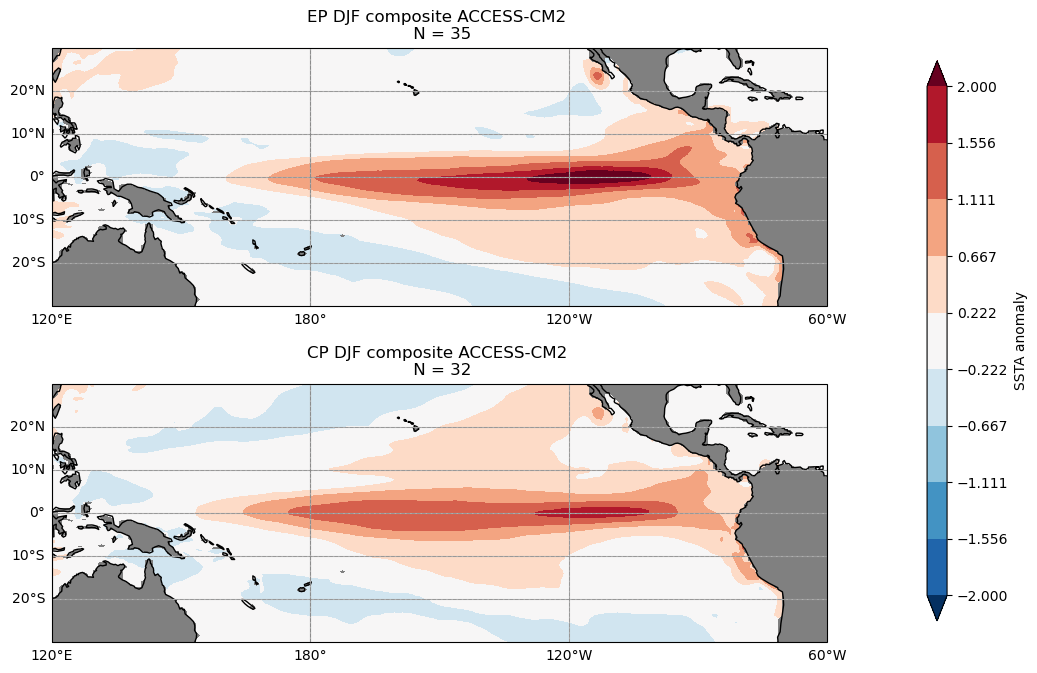

In [97]:
# Create figure with 2x2 grid of subplots
fig = plt.figure(figsize=(10, 8))

# Create a list to store the contourf objects for each subplot
contourf_objs = []

ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    
# Calculate the regression and plot it with contourf
cf = ep_djf_comp.plot.contourf(transform=ccrs.PlateCarree(),
                        vmin=-2, vmax=2, levels=10, extend='both', cmap="RdBu_r", ax=ax, add_colorbar = False)

plt.title("EP DJF composite ACCESS-CM2 \n N = 35")
ax.coastlines(color='k')
ax.gridlines()
ax.set_facecolor('grey')
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree(central_longitude=180))
    
# Calculate the regression and plot it with contourf
cf = cp_djf_comp.plot.contourf(transform=ccrs.PlateCarree(),
                        vmin=-2, vmax=2, levels=10, extend='both', cmap="RdBu_r", ax=ax, add_colorbar = False)

plt.title("CP DJF composite ACCESS-CM2 \n N = 32")
ax.coastlines(color='k')
ax.gridlines()
ax.set_facecolor('grey')
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Create a single colorbar for all subplots
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
cbar = plt.colorbar(cf, cax=cbar_ax)
cbar.set_label('SSTA anomaly')

#plt.tight_layout()
plt.show()

In [98]:
from scipy.stats import ttest_ind

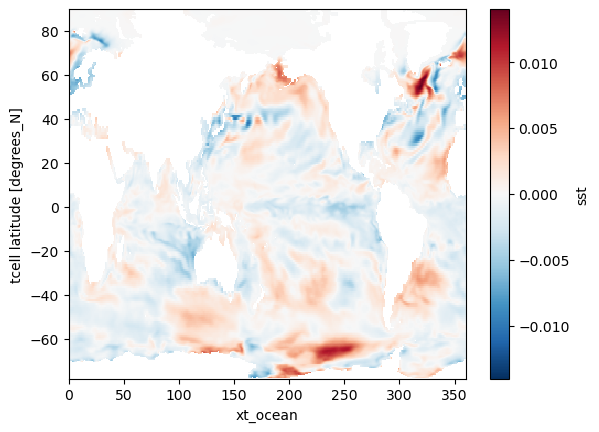

In [129]:
sst_anoms_djf.mean("year").plot()

In [125]:
t,p = ttest_ind(sst_anoms_djf, sst_anoms_djf[60], nan_policy="omit")

In [126]:
t_values_da = xr.DataArray(t, coords=[sst_anoms_djf.yt_ocean, sst_anoms_djf.xt_ocean], dims=['yt_ocean', 'xt_ocean'])
p_values_da = xr.DataArray(p, coords=[sst_anoms_djf.yt_ocean, sst_anoms_djf.xt_ocean], dims=['yt_ocean', 'xt_ocean'])

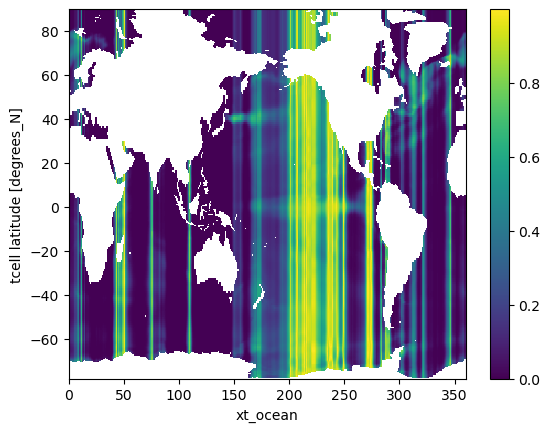

In [127]:
p_values_da.plot()

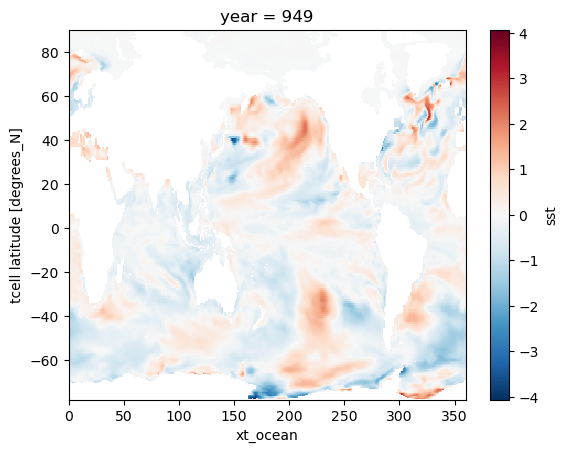

In [105]:
sst_anoms_djf[0].plot()

In [111]:
t

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [3.3698046303872884, 3.3018885244449607, 3.1544125791954114, ...,
         2.6314511349645633, 2.5584069556632514, 3.5527775207214125],
        [3.3698616568269886, 3.3020696356441266, 3.154749830415719, ...,
         2.6311706543642552, 2.558191073380168, 3.5527185940961177],
        [3.3696782415307767, 3.302053470582554, 3.1549234674568694, ...,
         2.6307083509883222, 2.557827231477863, 3.552411316789171]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20)

In [63]:
#regression of Ep index onto SSTA and Cp index onto SSTA in DJF

In [66]:
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])

In [67]:
def regress(var1, var2):
    slope = xr.apply_ufunc(linear_trend,
                        var1, var2,
                        vectorize=True,
                        dask = 'parallelized',
                        input_core_dims=[['year'], ['year']],# reduce along 'model'
                        )
    return slope

In [77]:
CP_DJF = CP.resample(
    time='QS-DEC').mean(
    dim="time").groupby('time.season')["DJF"].groupby(
    "time.year").mean("time")

In [78]:
EP_DJF = EP.resample(
    time='QS-DEC').mean(
    dim="time").groupby('time.season')["DJF"].groupby(
    "time.year").mean("time")

In [80]:
cf = regress(EP_DJF,sst_anoms_djf)

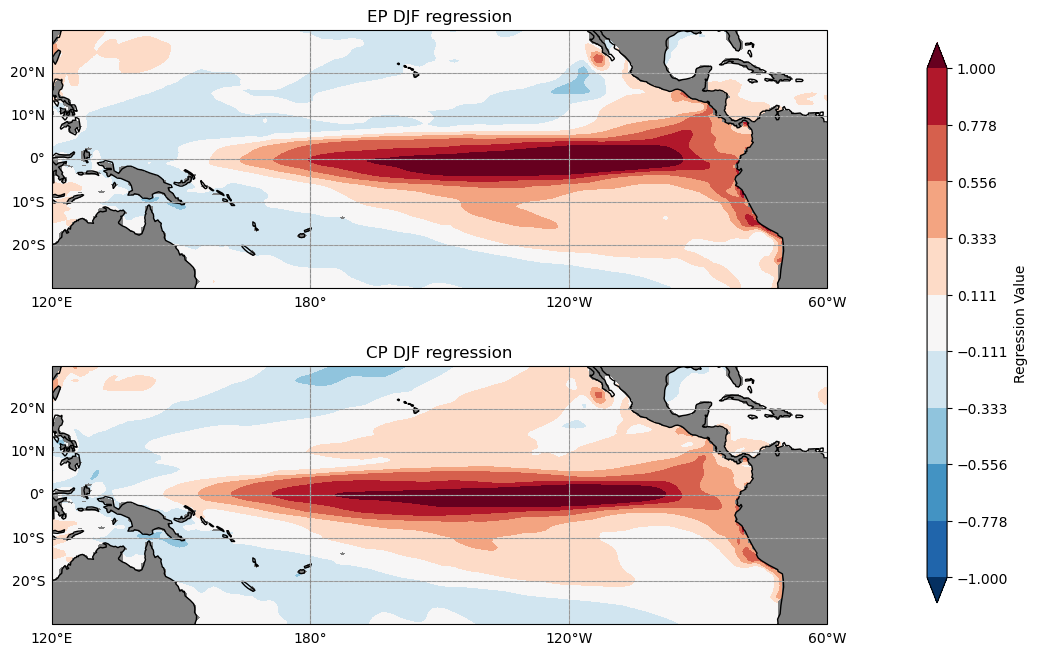

In [85]:
# Create figure with 2x2 grid of subplots
fig = plt.figure(figsize=(10, 8))

# Create a list to store the contourf objects for each subplot
contourf_objs = []

ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    
# Calculate the regression and plot it with contourf
cf = regress(EP_DJF,sst_anoms_djf).plot.contourf(transform=ccrs.PlateCarree(),
                        vmin=-1, vmax=1, levels=10, extend='both', cmap="RdBu_r", ax=ax, add_colorbar = False)

plt.title("EP DJF regression")
ax.coastlines(color='k')
ax.gridlines()
ax.set_facecolor('grey')
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree(central_longitude=180))
    
# Calculate the regression and plot it with contourf
cf = regress(CP_DJF,sst_anoms_djf).plot.contourf(transform=ccrs.PlateCarree(),
                        vmin=-1, vmax=1, levels=10, extend='both', cmap="RdBu_r", ax=ax, add_colorbar = False)

plt.title("CP DJF regression")
ax.coastlines(color='k')
ax.gridlines()
ax.set_facecolor('grey')
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Create a single colorbar for all subplots
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
cbar = plt.colorbar(cf, cax=cbar_ax)
cbar.set_label('Regression Value')

#plt.tight_layout()
plt.show()